# Classifiers for What's Cooking

This file implements the following classifiers for the What's Cooking challenge, in an attempt to match the accuracy benchmarks noted below, from Ghewani-Raiyani (ref 1 in our brief):

**KNN** - 60.75% <br>
**Decision Tree** - 62.59% <br>
**Naive Bayes** - 73.25% <br>
**Random Forest** 74.13%  with an accuracy of the second paper claims accuracy of 76.2% using diff features. <br> 
**Logistic Regression** - 81.25% <br>
**SVM** - 81.32% <br>

Note that as labels for the test set are not available, the above benchmarks represent accuracy on the validation set. 

## Exec Summary

At present the analysis shows that even using a very simplistic pipeline featuring a CountVectorizer on the untransformed read-in data followed by un-tuned classifiers we can achieve results within 4ppts of the benchmarks, as tested on a single validation fold. 

## Further Work

1. I believe the greatest results will be achieved by improving the feature selection stage. At present the vectoriser selects individual words (so 'ground black pepper' would count towards each of the 'ground','black' and 'pepper' tokens) and there has been no modification done on the ingredients. Automated approaches could look at reducing number of features, concatenating, combining phrases with a high degree similarity etc. Manual approaches could look at ingredients appearing over a certian number of times and flag where these should be combined. Might be worth exploring the effects of combining the bin&cluster&count approach from the 2nd paper with a more effective classifier such as an SVM. - Fahad & Dave

2. To turn this into more of a data mining project, we should look at adding more features through blending in other data sets. There are several available which give nutritional information, with a greater or lesser amount of manual processing required. FooDB is also worth considering - it only contains around 700 raw food items, but contains detail on their chemical compositions, allowing us to impute some idea about a taste profile! Difficulties will likely be encountered in the fact that processed foods such as soy sauce are not included in this database, so raw composite ingredients will need to be considered and summed. Substantial manual work will likely be required if this approach is taken. - ON HOLD, TO ASSESS IMPACT.

3. There is still machine learning work to be done as well, the classifiers were only selected due to inclusion in the benchmark paper, and many others could be tried. Following selection, a degree of parameter turning will need to be performed by creating additional validation folds. Additionally, given indicators that some predictors are stronger on different cuisines, we may want to explore ways to ensemble these. Shree & Dave

4. We also need visualisations to showcase our results in the report. I have included some in this notebook, but we will likely need a wider range - these can be done in an external program if preferred. - Fahad, Mehmet, Shree

5. To address some of the DM requirements, there was also talk of scraping and blending in additional recipes. Cuisine labels for these may not be available but if not it may be possible to use these to improve the quality of features for prediction. - Mariam & Sina

### Section 1: Data Read-In

Effectively the same as in the andrew_bag_of_words file, except loads in the data directly as a dataframe rather than using json + transform.

In [1]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [3]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

### Section 2: Analysis & Visualisation

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Visualising the recipe counts by cuisine.

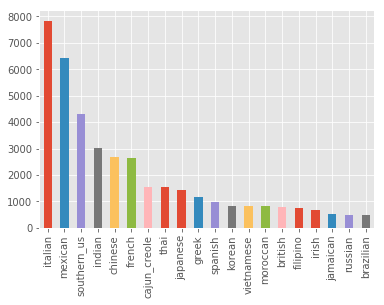

In [6]:
trainData['cuisine'].value_counts().plot(kind='bar')

Creating a table showing the 10 most common ingredients for each cuisine.

In [7]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [8]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

top1               top2               top3  \
greek               salt          olive oil      dried oregano   
southern_us         salt             butter  all-purpose flour   
filipino            salt             garlic              water   
indian              salt             onions       garam masala   
jamaican            salt             onions              water   
spanish             salt          olive oil      garlic cloves   
italian             salt          olive oil      garlic cloves   
mexican             salt             onions       ground cumin   
chinese        soy sauce         sesame oil               salt   
british             salt  all-purpose flour             butter   
thai          fish sauce             garlic               salt   
vietnamese    fish sauce              sugar               salt   
cajun_creole        salt             onions             garlic   
brazilian           salt             onions          olive oil   
french              salt              sugar  all-purpose flour   
japanese       soy sauce               salt              mirin   
irish               salt  all-purpose flour             butter   
korean         soy sauce         sesame oil             garlic   
moroccan            salt          olive oil       ground cumin   
russian             salt              sugar             onions   

                                top4                  top5  \
greek                  garlic cloves  feta cheese crumbles   
southern_us                    sugar            large eggs   
filipino                      onions             soy sauce   
indian                         water       ground turmeric   
jamaican                      garlic       ground allspice   
spanish       extra-virgin olive oil                onions   
italian       grated parmesan cheese                garlic   
mexican                       garlic             olive oil   
chinese                  corn starch                 sugar   
british                         milk                  eggs   
thai                    coconut milk         vegetable oil   
vietnamese                    garlic                 water   
cajun_creole       green bell pepper                butter   
brazilian                       lime                 water   
french               unsalted butter             olive oil   
japanese                       sugar                 water   
irish                         onions                 sugar   
korean                  green onions                 sugar   
moroccan                      onions       ground cinnamon   
russian            all-purpose flour            sour cream   

                                top6                    top7  \
greek         extra-virgin olive oil       fresh lemon juice   
southern_us            baking powder                   water   
filipino                      pepper                     oil   
indian                        garlic              cumin seed   
jamaican                      pepper               scallions   
spanish                        water                tomatoes   
italian          ground black pepper  extra-virgin olive oil   
mexican                 chili powder        jalapeno chilies   
chinese                       garlic                   water   
british              unsalted butter                   sugar   
thai                       soy sauce                   sugar   
vietnamese                   carrots               soy sauce   
cajun_creole               olive oil          cayenne pepper   
brazilian              garlic cloves                  garlic   
french                        butter                   water   
japanese                        sake            rice vinegar   
irish                       potatoes             baking soda   
korean                          salt                   water   
moroccan               garlic cloves                   water   
russian                         eggs              

We can see from the above that the presence of salt tells us very little, but something like fish sauce can narrow down the probable cuisines considerably. To see how big this effect is, we visualise the percentage of recipes that our most common ingredients are found in, for each cuisine.

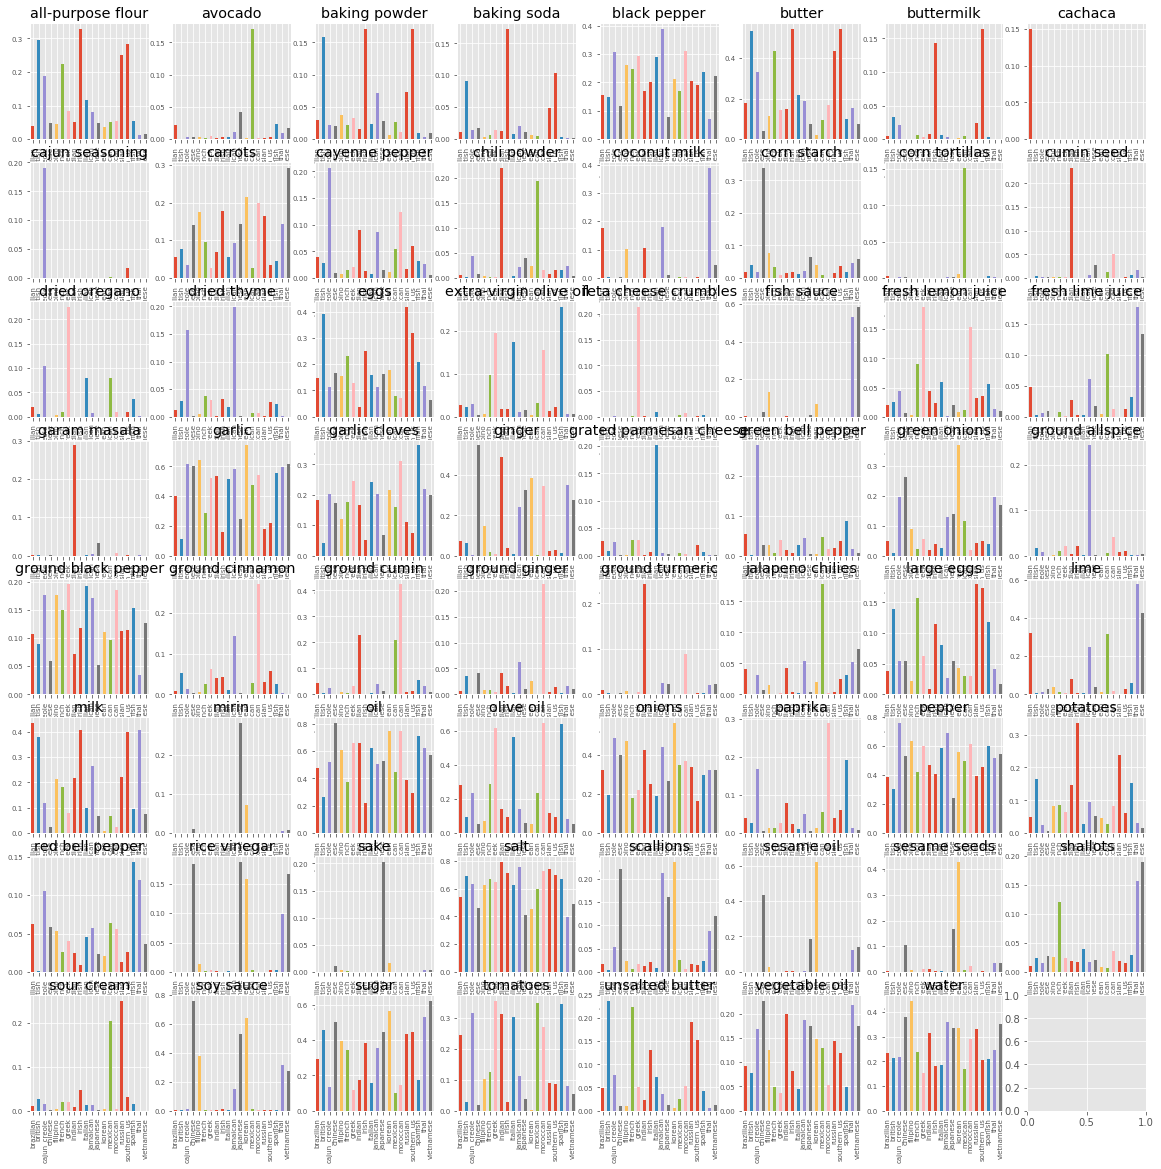

In [9]:
import numpy as np

unique = np.unique(top10.values.ravel())
trainData['all_ingredients'] = trainData['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = trainData['all_ingredients'].str.contains(ingredient)
    #indices = any(ingredient in s for s in trainData['ingredients'])
    relative_freq = (trainData[indices]['cuisine'].value_counts() / trainData['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


This indicates the above statement in a more understandable form - ingredients like water, butter and oil don't do much to differentiate between cuisines, whereas sake, feta cheese and garam masala are exceptionally informative.

This is, perhaps, not too surprising, and does indicate that a Naive Bayes classifier should perform very well on this dataset. 

### Section 3: Classifier Implementation

On the single fold of data tested (seed=37), the six classifiers implemented below achieved the following accuracy. Benchmarks are shown in brackets:

**KNN** - 64.44% *(60.75)* <br>
**Decision Tree** - 63.78% *(62.59)* <br>
**Naive Bayes** - 72.57% *(73.25)* <br>
**Random Forest** - 71.16% *(74.13)* <br>
**Logistic Regression** - 78.37% *(81.25)* <br>
**SVM (LinearSVC)** - 77.05% *(81.32)* <br>

For reference, on the test set a score of 82.07% would have been sufficient for a Top-10 placement, while the competition winner scored 83.02%.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(trainData['all_ingredients'], trainData['cuisine'], test_size=0.2, random_state=37)

#### At this point we are splitting all of the ingredients into 1 and 2 word ngrams


In [11]:
cv = CountVectorizer(ngram_range=(1, 2))
X_train_vec = cv.fit_transform(X_train.values)
X_test_vec = cv.transform(X_test.values)
X_train_vec.shape

(31819, 72118)

In [12]:
X_test_vec.shape

(7955, 72118)

In [13]:
print(list(cv.vocabulary_.keys())[:100])

['tomato', 'sauce', 'ground', 'black', 'pepper', 'garlic', 'scallions', 'chipotles', 'in', 'adobo', 'avocado', 'dried', 'thyme', 'instant', 'white', 'rice', 'cilantro', 'leaves', 'coconut', 'milk', 'water', 'red', 'beans', 'chopped', 'celery', 'skinless', 'chicken', 'thighs', 'onions', 'lime', 'zest', 'juice', 'wedges', 'salt', 'carrots', 'tomato sauce', 'sauce ground', 'ground black', 'black pepper', 'pepper garlic', 'garlic scallions', 'scallions chipotles', 'chipotles in', 'in adobo', 'adobo avocado', 'avocado dried', 'dried thyme', 'thyme instant', 'instant white', 'white rice', 'rice cilantro', 'cilantro leaves', 'leaves coconut', 'coconut milk', 'milk water', 'water red', 'red beans', 'beans chopped', 'chopped celery', 'celery skinless', 'skinless chicken', 'chicken thighs', 'thighs onions', 'onions lime', 'lime zest', 'zest lime', 'lime juice', 'juice lime', 'lime wedges', 'wedges salt', 'salt carrots', 'coarse', 'fresh', 'mint', 'soy', 'freshly', 'clarified', 'butter', 'phyllo'

The below encodes the labels, mapping brazilian:vietnamese -> 0:19

Lastly it's worth checking our validation fold has a representative number of each cuisine in the set. We will of course perform later refolding and validation, but don't want to invalidate the results we'll be commenting on. The graph appears to be showing roughly the same proportions as present in the initial trainData set, so we can proceed.

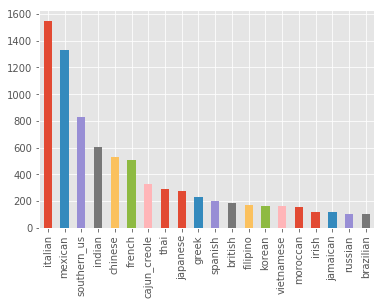

In [14]:
y_test.value_counts().plot(kind='bar')

#### Section 3.1: KNN Classifer

#### This is a modification to the fit, using the original train set labels rather than label encoder


In [19]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_vec, y_train)

neigh.score(X_test_vec, y_test)

0.5366436203645506

In [20]:
#this is for the classification report y labels
cuisines = trainData['cuisine'].value_counts(sort=False).index
cuisines

Index(['irish', 'british', 'japanese', 'mexican', 'brazilian', 'italian',
       'southern_us', 'moroccan', 'jamaican', 'vietnamese', 'russian',
       'indian', 'spanish', 'chinese', 'cajun_creole', 'french', 'korean',
       'filipino', 'thai', 'greek'],
      dtype='object')

In [22]:
type(cuisines)

pandas.core.indexes.base.Index

In [21]:
#this is for the classification report y target_names
cuisineslist = cuisines.tolist()

In [22]:
neigh_pred = neigh.predict(X_test_vec)
print(classification_report(y_test, neigh_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.51      0.17      0.26       121
     british       0.21      0.15      0.17       184
    japanese       0.31      0.57      0.40       276
     mexican       0.73      0.73      0.73      1331
   brazilian       0.41      0.32      0.36       102
     italian       0.48      0.86      0.62      1550
 southern_us       0.51      0.53      0.52       828
    moroccan       0.70      0.21      0.32       152
    jamaican       0.95      0.18      0.30       117
  vietnamese       0.59      0.27      0.37       163
     russian       0.00      0.00      0.00       104
      indian       0.69      0.58      0.63       605
     spanish       0.62      0.05      0.09       201
     chinese       0.74      0.47      0.58       529
cajun_creole       0.78      0.26      0.39       327
      french       0.30      0.47      0.37       508
      korean       0.68      0.43      0.53       165
    filipino       0.61    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Section 3.2: Decision Tree Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [23]:
from sklearn import tree

dec = tree.DecisionTreeClassifier()
dec.fit(X_train_vec, y_train)

dec.score(X_test_vec, y_test)

0.6447517284726587

In [24]:
dec_pred = dec.predict(X_test_vec)
print(classification_report(y_test, dec_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.35      0.31      0.33       121
     british       0.28      0.19      0.23       184
    japanese       0.64      0.55      0.59       276
     mexican       0.81      0.84      0.82      1331
   brazilian       0.50      0.37      0.43       102
     italian       0.73      0.78      0.75      1550
 southern_us       0.58      0.62      0.60       828
    moroccan       0.54      0.54      0.54       152
    jamaican       0.60      0.42      0.49       117
  vietnamese       0.54      0.48      0.51       163
     russian       0.30      0.18      0.23       104
      indian       0.72      0.77      0.74       605
     spanish       0.37      0.33      0.35       201
     chinese       0.69      0.72      0.70       529
cajun_creole       0.62      0.56      0.59       327
      french       0.40      0.45      0.42       508
      korean       0.69      0.66      0.67       165
    filipino       0.47    

Code courtesy of Stack Overflow - aim is to convert the above decision tree into a pythonic if-else statement so we can examine the decisions being made. Output is considerably too lengthy for easy reading, but we can see the low entropy of outputs at nearly all of the leaf nodes, indicating this tree is probably overfitting.

In [25]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [26]:
tree_to_code(dec,cv.get_feature_names())

def tree(10, 10 oz, 100, 100 blackberry, 14, 14 oz, 15, 15 oz, 25, 25 less, 33, 33 less, 40, 40 less, 43, 43 ice, 95, 95 lean, 96, 96 fat, abalone, abalone toasted, abbamele, abbamele wild, absinthe, absinthe twists, abura, abura age, acai, acai juice, acai puree, accent, accent nuts, accent seasoning, accent spaghetti, achiote, achiote bone, achiote fresh, achiote ground, achiote guacamole, achiote paste, achiote powder, achiote sazon, achiote scallions, acid, acid dried, acid powder, acid rennet, acid white, acini, acini di, ackee, ackee codfish, ackee creole, ackee garlic, ackee oil, ackee onions, ackee salt, acorn, acorn squash, acting, acting baking, activ, activ garlic, active, active dry, added, added black, added chicken, added diced, adobo, adobo achiote, adobo all, adobo avocado, adobo bacon, adobo black, adobo bone, adobo bread, adobo brown, adobo cabbage, adobo canola, adobo chicken, adobo chopped, adobo chuck, adobo cilantro, adobo cinnamon, adobo clove, adobo coarse, adob

                                                                                                                                                                                                    if whipped cream <= 0.5:
                                                                                                                                                                                                      if sugar whipping <= 0.5:
                                                                                                                                                                                                        if bananas <= 0.5:
                                                                                                                                                                                                          if onions <= 0.5:
                                                                                                                    

                                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                    else:  # if peppercorns > 0.5
                                                                                                                                      return [[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                  else:  # if pastry > 0.5
                                                                                                                                    return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  

                                                                                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                                                                                                    else:  # if apples all > 0.5
                                                                                                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
                                                                                                                                                              else:  # if onion > 0.5
                                                                                                                                                     

                                                                                                                                  if flour <= 0.5:
                                                                                                                                    if pepper salt <= 0.5:
                                                                                                                                      if bean <= 0.5:
                                                                                                                                        if dried <= 0.5:
                                                                                                                                          if onions <= 0.5:
                                                                                                                                            if cooking <= 0.5:
                                                                                

                                                                                                        else:  # if onions > 0.5
                                                                                                          if cooking oil <= 0.5:
                                                                                                            if juice <= 0.5:
                                                                                                              if beef <= 0.5:
                                                                                                                if garlic cloves <= 0.5:
                                                                                                                  if eggs <= 0.5:
                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                     

                                                                                        if lemon <= 0.5:
                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if lemon > 0.5
                                                                                          return [[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                      else:  # if garlic > 0.5
                                                                                        return [[0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                    else:  # if large > 0.5
                                                                                   

                                                                                                                                        else:  # if eggs > 0.5
                                                                                                                                          if fried rice <= 0.5:
                                                                                                                                            return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                          else:  # if fried rice > 0.5
                                                                                                                                            return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            

                                        if tomatoes ghee <= 0.5:
                                          if shoulder green <= 0.5:
                                            if turmeric pepper <= 0.5:
                                              if seeds baking <= 0.5:
                                                if powder ajwain <= 0.5:
                                                  return [[ 0.  0.  0.  0.  0.  0.  0. 67.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]
                                                else:  # if powder ajwain > 0.5
                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if seeds baking > 0.5
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if turmeric pepper > 0.5
                                   

                                                                                                        else:  # if mint ground > 0.5
                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
                                                                                                      else:  # if flour butter > 0.5
                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                  else:  # if creole > 0.5
                                                                                                    if fresh <= 0.5:
                                                                                                      return [[0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 

                                                                              return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if powder chopped > 0.5
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  else:  # if sugar vegetable > 0.5
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.]]
                                                                else:  # if cream > 0.5
                                                                  if green <= 0.5:
                                                                    if cheese <= 0.5:
                                                                      if sour <= 0.5:
           

                                                                                                                          else:  # if preserves large > 0.5
                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                        else:  # if che unsalted > 0.5
                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                      else:  # if chipotle chile > 0.5
                                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0

                                                            return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if asparagus > 0.5
                                                        if large <= 0.5:
                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                        else:  # if large > 0.5
                                                          return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if pepper > 2.0
                                                      return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if sage > 0.5
                                                    if vegetable oil <= 0.5:
                        

                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0.]]
                                                else:  # if butter pure > 0.5
                                                  return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if whole > 0.5
                                                return [[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if extract milk > 0.5
                                            return [[0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                        else:  # if chocolate all > 0.5
                                          return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                      else:  # if maple sugar > 0.5
                                        return [[0

                                      if masala <= 0.5:
                                        if reduced <= 0.5:
                                          if scallions <= 0.5:
                                            if quarters <= 0.5:
                                              if fresh parsley <= 0.5:
                                                if paste water <= 0.5:
                                                  if black sesame <= 0.5:
                                                    if breast halves <= 0.5:
                                                      return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  14.  0.]]
                                                    else:  # if breast halves > 0.5
                                                      return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if black sesame > 0.5
                            

                                                else:  # if brown sugar > 0.5
                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if beansprouts > 0.5
                                              if chopped cilantro <= 0.5:
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                              else:  # if chopped cilantro > 0.5
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if tumeric > 0.5
                                            return [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                        else:  # if pizza > 0.5
                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 

                                                                                                                                                                                          else:  # if beef rib > 0.5
                                                                                                                                                                                            return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                                      else:  # if liqueur > 0.5
                                                                                                                                                                                        if sugar salt <= 0.5:
                                                                                                                  

                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                                              else:  # if pepper black > 0.5
                                                                                                                return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                            else:  # if leg > 0.5
                                                                                                              return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                          else:  # if tentacles > 0.5
                                              

                                                                                        else:  # if large eggs > 0.5
                                                                                          return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                    else:  # if quinoa > 0.5
                                                                                      if baby <= 0.5:
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
                                                                                      else:  # if baby > 0.5
                                                                                        return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                  el

                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if goat > 0.5
                                                        if leeks <= 0.5:
                                                          if fresh thyme <= 0.5:
                                                            if eggs <= 0.5:
                                                              if oil goat <= 0.5:
                                                                if vinegar english <= 0.5:
                                                                  if pecans <= 0.5:
                                                                    if salmon shallots <= 0.5:
                                                                      return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0. 26.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]
                                               

                          else:  # if eyed peas > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0.]]
                      else:  # if saffron > 0.5
                        if raisins <= 0.5:
                          return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 34.
   0.  0.]]
                        else:  # if raisins > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]]
                    else:  # if powder > 0.5
                      if wine <= 0.5:
                        if lime <= 0.5:
                          if cream cheese <= 0.5:
                            if vinegar <= 0.5:
                              if eggs <= 0.5:
                                if thyme pinenuts <= 0.5:
                                  if yogurt lemon <= 0.5:
                                    if paprika sugar <= 0.5:
                                      if shallo

                                                                                                                                                                    if oregano seasoning <= 0.5:
                                                                                                                                                                      if celery oregano <= 0.5:
                                                                                                                                                                        if pork vegetable <= 0.5:
                                                                                                                                                                          if shrimp tomatoes <= 0.5:
                                                                                                                                                                            if chorizo jalapeno <= 0.5:
                        

                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if canned black > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if vidalia onion > 0.5
                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if hominy > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                else:  # if skinless chicken > 0.5
                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              el

                                                              else:  # if red > 0.5
                                                                if red wine <= 0.5:
                                                                  if sushi rice <= 0.5:
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  else:  # if sushi rice > 0.5
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if red wine > 0.5
                                                                  if wine low <= 0.5:
                                                                    return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                       

                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if oil green > 0.5
                                                    if brown <= 0.5:
                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                                    else:  # if brown > 0.5
                                                      return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if sauce > 1.5
                                                if sauce orange <= 0.5:
                                                  if cloves brown <= 0.5:
                                                    return [[0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if clo

                            return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                        else:  # if green onions > 0.5
                          if sriracha <= 0.5:
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]
                          else:  # if sriracha > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                    else:  # if ginger dipping > 0.5
                      if sesame <= 0.5:
                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                      else:  # if sesame > 0.5
                        if beef dough <= 0.5:
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                        else:  # if beef dough > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                  els

                                                                                if black pepper <= 0.5:
                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                                                                                else:  # if black pepper > 0.5
                                                                                  return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if nutmeg whole > 0.5
                                                                              if sauce shallots <= 0.5:
                                                                                return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                              else:  # if sauce shallots > 0.5
      

#### Section 3.3: Naive Bayes Classifer

###### This is a modification to the original, using the y train and y test (cuisines) instead of the label encoded versions


In [37]:
from sklearn.naive_bayes import MultinomialNB

bayes = MultinomialNB()
#todense() method used to coerce ndarray from csr (sparse) to dense format
#only seemed to be throwing errors on the training matrix, unsure why
bayes.fit(X_train_vec.todense(), y_train)

MemoryError: 

In [ ]:
bayes.score(X_test_vec.todense(), y_test)

In [40]:
bayes_pred = bayes.predict(X_test_vec.todense())
print(classification_report(y_test, bayes_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.74      0.87      0.80       529
      korean       0.80      0.73      0.77       165
 southern_us       0.56      0.73      0.63       828
     mexican       0.91      0.87      0.89      1331
     italian       0.83      0.79      0.81      1550
      indian       0.84      0.86      0.85       605
     spanish       0.52      0.50      0.51       201
    filipino       0.75      0.46      0.57       171
    moroccan       0.68      0.80      0.73       152
     russian       0.69      0.30      0.42       104
   brazilian       0.53      0.28      0.37       102
       greek       0.65      0.62      0.64       229
cajun_creole       0.60      0.77      0.67       327
      french       0.50      0.54      0.52       508
     british       0.35      0.33      0.34       184
       irish       0.56      0.39      0.46       121
    japanese       0.89      0.62      0.73       276
    jamaican       0.85    

#### Section 3.4: Random Forest Classifer

In [30]:
from sklearn.ensemble import RandomForestClassifier

frst = RandomForestClassifier(random_state=37)
frst.fit(X_train_vec, y_train)

frst.score(X_test_vec, y_test)

0.6745443117536141

In [31]:
frst_pred = frst.predict(X_test_vec)
print(classification_report(y_test, frst_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.58      0.25      0.35       121
     british       0.39      0.22      0.28       184
    japanese       0.70      0.52      0.60       276
     mexican       0.81      0.88      0.84      1331
   brazilian       0.65      0.42      0.51       102
     italian       0.67      0.88      0.76      1550
 southern_us       0.62      0.64      0.63       828
    moroccan       0.78      0.38      0.51       152
    jamaican       0.74      0.36      0.48       117
  vietnamese       0.67      0.27      0.38       163
     russian       0.53      0.09      0.15       104
      indian       0.74      0.84      0.79       605
     spanish       0.67      0.20      0.31       201
     chinese       0.63      0.81      0.71       529
cajun_creole       0.66      0.62      0.64       327
      french       0.45      0.49      0.47       508
      korean       0.68      0.46      0.55       165
    filipino       0.65    

#### Section 3.5: Logistic Regression Classifer

In [32]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_vec, y_train)

logistic.score(X_test_vec, y_test)

0.7829038340666248

Text(0.5,64.6,'Predicted label')

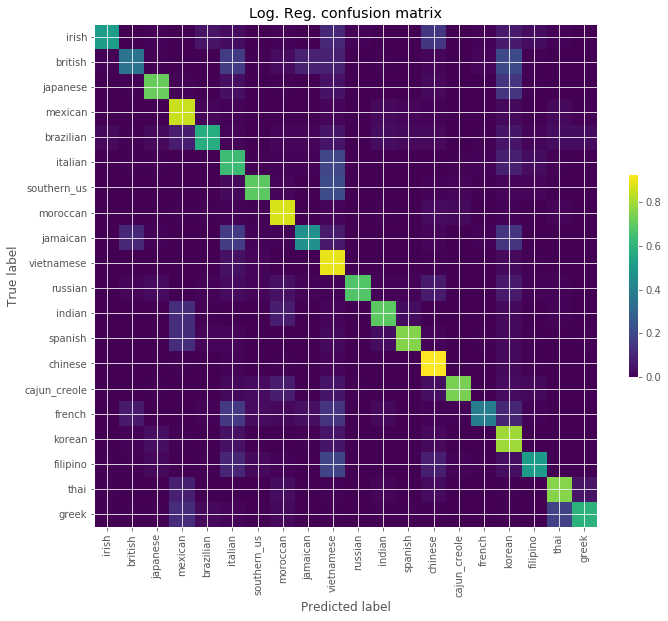

In [33]:
plt.figure(figsize=(10, 10))

log_cm = confusion_matrix(y_test, logistic.predict(X_test_vec))
log_cm_normalized = log_cm.astype('float') / log_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(log_cm_normalized, interpolation='nearest')
plt.title("Log. Reg. confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [34]:
log_pred = logistic.predict(X_test_vec)
print(classification_report(y_test, log_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.62      0.47      0.54       121
     british       0.59      0.36      0.45       184
    japanese       0.82      0.70      0.75       276
     mexican       0.91      0.93      0.92      1331
   brazilian       0.75      0.52      0.61       102
     italian       0.79      0.90      0.84      1550
 southern_us       0.70      0.80      0.75       828
    moroccan       0.83      0.74      0.78       152
    jamaican       0.91      0.68      0.77       117
  vietnamese       0.81      0.60      0.69       163
     russian       0.68      0.39      0.50       104
      indian       0.87      0.87      0.87       605
     spanish       0.65      0.51      0.57       201
     chinese       0.78      0.85      0.81       529
cajun_creole       0.79      0.71      0.75       327
      french       0.57      0.64      0.60       508
      korean       0.82      0.76      0.79       165
    filipino       0.73    

#### Note altered cuisines of concern

Although the raw accuracy score looks good, the confusion matrix and particularly the analysis of the recall show a different story for some cuisines. Spanish, Russian and British dishes are more likely to be classified as other cuisines than they are themselves, indicating that there may be few stand-out ingredients for these cuisines.

#### Section 3.6: SVM Classifer

In [35]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=37)
lsvc.fit(X_train_vec, y_train)

lsvc.score(X_test_vec, y_test)

0.7586423632935261

Text(0.5,64.6,'Predicted label')

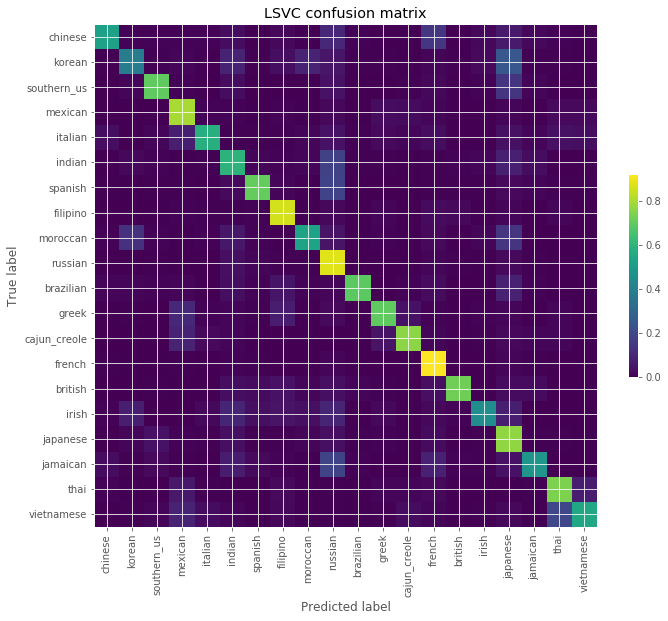

In [48]:
plt.figure(figsize=(10, 10))

lsvc_cm = confusion_matrix(y_test, lsvc.predict(X_test_vec))
lsvc_cm_normalized = lsvc_cm.astype('float') / lsvc_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(lsvc_cm_normalized, interpolation='nearest')
plt.title("LSVC confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [36]:
lsvc_pred = lsvc.predict(X_test_vec)
print(classification_report(y_test, lsvc_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

       irish       0.52      0.49      0.50       121
     british       0.57      0.43      0.49       184
    japanese       0.77      0.68      0.73       276
     mexican       0.90      0.91      0.90      1331
   brazilian       0.68      0.53      0.60       102
     italian       0.81      0.87      0.84      1550
 southern_us       0.70      0.74      0.72       828
    moroccan       0.76      0.70      0.73       152
    jamaican       0.74      0.68      0.71       117
  vietnamese       0.70      0.60      0.64       163
     russian       0.57      0.41      0.48       104
      indian       0.84      0.85      0.85       605
     spanish       0.51      0.48      0.49       201
     chinese       0.77      0.81      0.79       529
cajun_creole       0.73      0.69      0.71       327
      french       0.55      0.60      0.58       508
      korean       0.78      0.75      0.76       165
    filipino       0.66    

#### Bonus section: implementing pipelines from andrew_bag_of_words to compare results

In [55]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),
                         ])

text_clf_svm.fit(X_train, y_train)
text_clf_svm.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.7063482086737901

In [183]:
pipe_svm_pred = text_clf_svm.predict(X_test)
print(classification_report(y_test, pipe_svm_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.75      0.26      0.39       102
     mexican       0.57      0.11      0.18       184
 southern_us       0.71      0.67      0.69       327
      indian       0.65      0.87      0.74       529
     chinese       0.82      0.23      0.36       171
      french       0.63      0.38      0.47       508
cajun_creole       0.76      0.54      0.63       229
        thai       0.74      0.89      0.81       605
    japanese       0.62      0.23      0.34       121
       greek       0.68      0.93      0.78      1550
     spanish       0.84      0.44      0.57       117
      korean       0.80      0.61      0.69       276
  vietnamese       0.76      0.45      0.57       165
    moroccan       0.82      0.93      0.87      1331
     british       0.80      0.49      0.60       152
    filipino       0.66      0.26      0.37       104
       irish       0.61      0.74      0.67       828
    jamaican       0.66    

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_nb.fit(X_train, y_train)
pipe_nb.score(X_test,y_test)

0.6764299182903835

In [56]:
pipe_nb_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, pipe_nb_pred, labels = cuisines, target_names=cuisineslist))

              precision    recall  f1-score   support

     chinese       0.59      0.90      0.72       529
      korean       0.93      0.38      0.54       165
 southern_us       0.50      0.80      0.61       828
     mexican       0.80      0.92      0.86      1331
     italian       0.66      0.91      0.76      1550
      indian       0.76      0.90      0.83       605
     spanish       0.96      0.11      0.20       201
    filipino       0.95      0.11      0.20       171
    moroccan       0.96      0.34      0.50       152
     russian       1.00      0.02      0.04       104
   brazilian       1.00      0.19      0.31       102
       greek       0.89      0.33      0.48       229
cajun_creole       0.80      0.50      0.61       327
      french       0.53      0.42      0.47       508
     british       0.81      0.07      0.13       184
       irish       0.93      0.11      0.19       121
    japanese       0.94      0.57      0.71       276
    jamaican       0.95    

This is actually the most interesting result so far. The high precision and horrendous recall on Spanish, Filipino, British, Irish and Jamaican suggest that the classifier is barely predicting these cuisines at all. That said, the f-score is very high for other cuisines such as Mexican, Indian, Italian, Chinese, suggesting that this could be used as part of a One vs All classifier ensemble, specifically for dealing with those cuisines.

Text(0.5,64.6,'Predicted label')

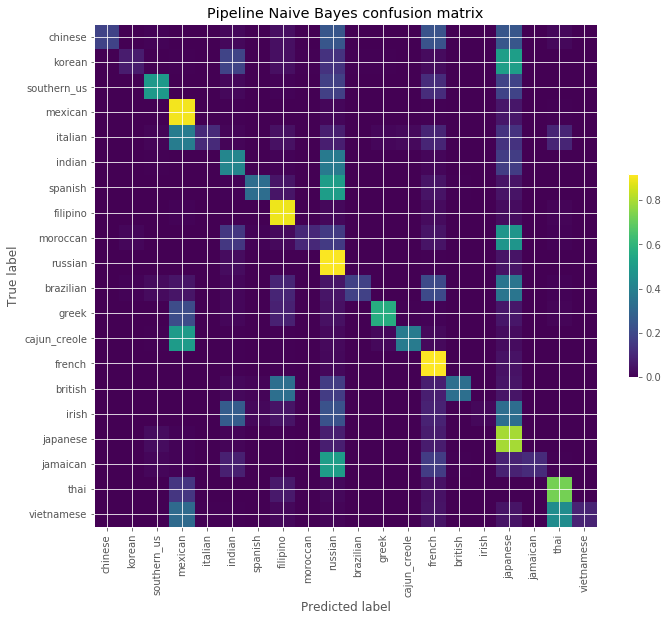

In [57]:
plt.figure(figsize=(10, 10))

pipe_nb_cm = confusion_matrix(y_test, pipe_nb.predict(X_test))
pipe_nb_cm_normalized = pipe_nb_cm.astype('float') / pipe_nb_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(pipe_nb_cm_normalized, interpolation='nearest')
plt.title("Pipeline Naive Bayes confusion matrix")
plt.colorbar(shrink=0.3)

tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')